# Put Pricing under the Black Scholes Model

Author: Jose Melo

## Imports

In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import norm
from optimizer import *
from nets import *
from fd import *
from matplotlib import cm
import json
import time

%matplotlib widget

DTYPE = torch.float64
DEV   = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(DTYPE)

## Parameters

In [55]:
STRIKE = 100
S_MIN, S_MAX =  1e-4, 2*STRIKE
X_MIN, X_MAX = np.log(S_MIN/STRIKE), np.log(S_MAX/STRIKE)   

T     = 1.0      # years to expiry
K     = 100.0    # strike
r     = 0.03     # risk-free (flat)
q     = 0.00     # dividend yield
SIGMA = 0.20     # volatility

In [56]:
def sample_domain(n_int=25_000, n_bdry=25_000, n_pay=25_000):
    # interior ----------------------------------------------------
    inter       = np.random.rand(n_int, 2)
    inter[:, 0] = inter[:, 0] * T                       
    inter[:, 1] = inter[:, 1]*(X_MAX-X_MIN) + X_MIN 

    # bottom boundary  x = X_MIN ------------------------------
    bot         = np.random.rand(n_bdry, 2)
    bot[:, 0]   = bot[:, 0] * T
    bot[:, 1]   = X_MIN

    # top boundary  x = X_MAX -------------------------------
    top         = np.random.rand(n_bdry, 2)
    top[:, 0]   = top[:, 0] * T
    top[:, 1]   = X_MAX

    # terminal condition  tau = 0 ------------------------------
    pay         = np.random.rand(n_pay, 2)
    pay[:, 0]   = 0.0
    pay[:, 1]   = pay[:, 1]*(X_MAX-X_MIN) + X_MIN

    X = np.vstack([inter, bot, top, pay])
    return torch.tensor(X, dtype=DTYPE, device=DEV)

In [57]:
def pde_residual(model, X):    
    X.requires_grad_(True)
    u      = model(X)
    grads  = torch.autograd.grad(u.sum(), X, create_graph=True)[0]
    u_tau, u_x  = grads[:, 0], grads[:, 1]
    u_xx        = torch.autograd.grad(u_x.sum(), X, create_graph=True)[0][:, 1]
    return -u_tau + 0.5 * SIGMA**2 * (u_xx - u_x) + r * u_x - r * u, u

def pde_loss(model, X):        
    _, x = X.t()
    H = torch.maximum(1.0 - torch.exp(x), torch.zeros_like(x))
    pde, u = pde_residual(model, X)    
    return torch.maximum(H - u, pde).pow(2).mean()

def loss_fn(model, X):
    tau, x = X.t()
    interior = (tau > 0) & (tau < T) & (x > X_MIN) & (x < X_MAX)
    bot     = x == X_MIN
    top     = x == X_MAX
    payoff  = tau == 0

    # interior
    l_int = pde_loss(model, X[interior])
    
    V_top = model(X[top])
    l_top = V_top.pow(2).mean()

    # top boundary  d2V/dx2 - dV/dx = 0
    X_bot = X[bot].requires_grad_(True)
    V_bot = model(X_bot)
    Vx_bot = torch.autograd.grad(V_bot.sum(), X_bot, create_graph=True)[0][:, 1]
    Vxx_bot = torch.autograd.grad(Vx_bot.sum(), X_bot, create_graph=True)[0][:, 1]
    l_bot = (Vxx_bot - Vx_bot).pow(2).mean()


    # payoff
    x_pay = x[payoff]
    payoff_val = torch.maximum(1.0 - torch.exp(x_pay), torch.zeros_like(x_pay))
    l_pay = (model(X[payoff]) - payoff_val).pow(2).mean()

    print("loss int {:8.2e}  bot {:8.2e}  top {:8.2e}  pay {:8.2e}".format(l_int.item(), l_bot.item(), l_top.item(), l_pay.item()))
    return l_int, l_bot, l_top, l_pay

## Training

In [58]:
X = sample_domain()

In [59]:
model = MLP(in_dim=2, hidden_layers=[20, 20], out_dim=1).to(DEV)
for p in model.parameters():
    if p.dim()>1: nn.init.xavier_uniform_(p)

In [37]:
opt = SSBroyden(model.parameters(), max_iter=20_000, tolerance_change=1e-10, tolerance_grad=1e-10)

benchmark = {'interior': [], 'bottom': [], 'top': [], 'payoff': [], 'total_loss': [], 'time': 0.0}
def closure(*args, **kwargs):
    opt.zero_grad()
    l_int, l_bot, l_top, l_pay = loss_fn(model, X)
    loss = l_int + l_bot + l_top + l_pay
    benchmark["interior"].append(l_int.item())
    benchmark["bottom"].append(l_bot.item())
    benchmark["top"].append(l_top.item())
    benchmark["payoff"].append(l_pay.item())
    benchmark["total_loss"].append(loss.item())
    loss.backward()
    return loss

start = time.time()
opt.step(closure)
end = time.time()
benchmark["time"] = end - start
print("training finished")

loss int 2.89e-01  bot 4.09e-03  top 1.10e-01  pay 4.19e-01
loss int 1.18e-01  bot 2.29e-02  top 1.18e-02  pay 2.71e-01
loss int 1.18e-01  bot 2.29e-02  top 1.18e-02  pay 2.71e-01
loss int 1.11e-01  bot 2.08e-02  top 7.75e-03  pay 2.42e-01
loss int 1.11e-01  bot 2.08e-02  top 7.75e-03  pay 2.42e-01
loss int 1.05e-01  bot 1.88e-02  top 7.40e-03  pay 2.24e-01
loss int 5.58e-02  bot 4.04e-03  top 5.02e-03  pay 7.70e-02
loss int 5.58e-02  bot 4.04e-03  top 5.02e-03  pay 7.70e-02
loss int 5.41e-02  bot 3.65e-03  top 4.94e-03  pay 7.32e-02
loss int 3.75e-02  bot 9.23e-04  top 4.31e-03  pay 4.79e-02
loss int 3.75e-02  bot 9.23e-04  top 4.31e-03  pay 4.79e-02
loss int 3.59e-02  bot 7.89e-04  top 4.29e-03  pay 4.60e-02
loss int 2.87e-02  bot 3.14e-04  top 4.21e-03  pay 3.79e-02
loss int 2.87e-02  bot 3.14e-04  top 4.21e-03  pay 3.79e-02
loss int 2.38e-02  bot 1.12e-04  top 4.05e-03  pay 3.24e-02
loss int 8.82e-03  bot 7.22e-04  top 3.24e-03  pay 1.65e-02
loss int 8.82e-03  bot 7.22e-04  top 3.2

## Training time 5.36m

In [38]:
torch.save(model.state_dict(), "american.pt")

In [60]:
model.load_state_dict(torch.load("american.pt"))

<All keys matched successfully>

In [61]:
model.eval()
with torch.no_grad():
    tau = torch.linspace(0, T, 100, device=DEV)
    x = torch.linspace(X_MIN, X_MAX, 100, device=DEV)
    t = (1-tau)*T
    s = STRIKE * torch.exp(x)
    tau, x = torch.meshgrid(tau, x, indexing="ij")

    x = torch.stack([tau.reshape(-1), x.reshape(-1)], dim=1)
    u = model(x).reshape(tau.shape)
    v = u*STRIKE


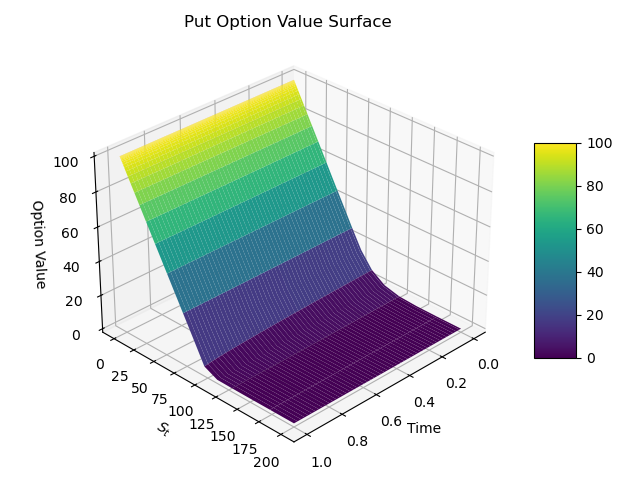

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tt, ss = np.meshgrid(t, s, indexing='ij')

surf = ax.plot_surface(tt, ss, v.cpu().numpy(),
                       cmap='viridis', edgecolor='none')

ax.set_xlabel('Time')
ax.set_ylabel('$S_t$')
ax.set_zlabel('Option Value')
ax.set_title('Put Option Value Surface')

# Rotate the view - adjust elevation and azimuth angles
ax.view_init(elev=30, azim=45)

plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

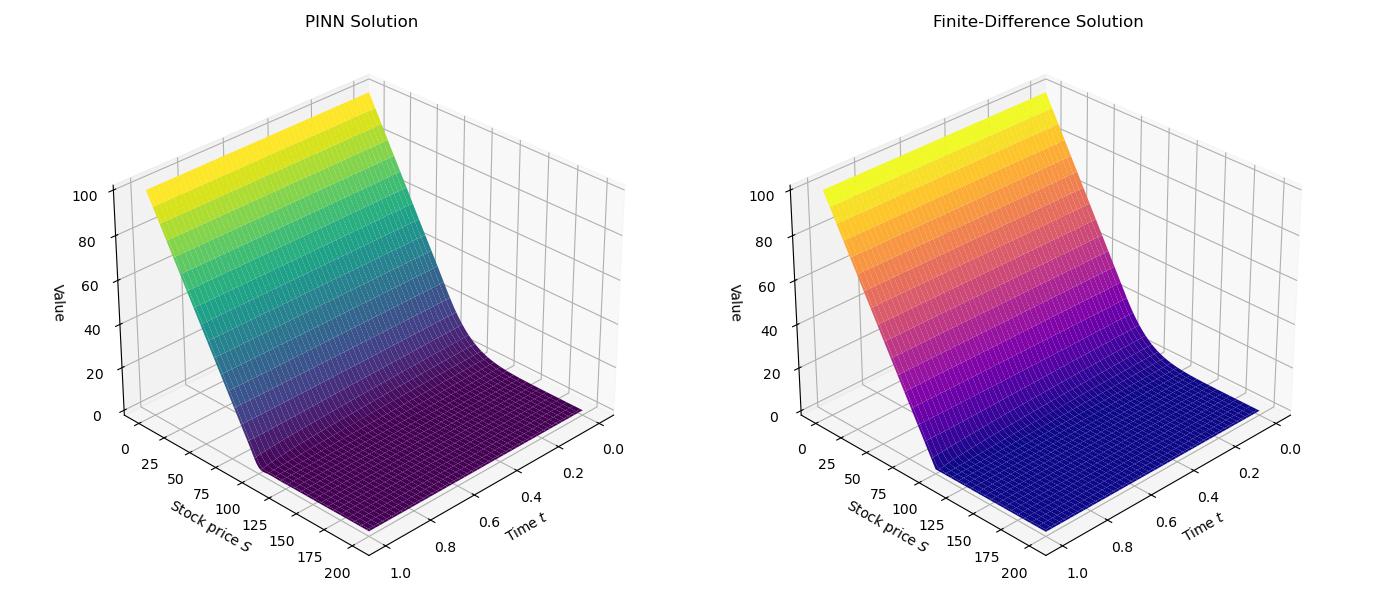

In [63]:
nas = 100                                            # space steps
v_fd, s_fd, t_fd = option_value_fd_american(SIGMA, r,
                                            STRIKE, T,
                                            option_type='put',
                                            nas=nas)
v_fd = np.flipud(v_fd.T)                                       # shape (nt, ns)

# ───────────────────────── 2)  PINN on the same grid ─────────────────
tau_grid  = 1.0 - torch.tensor(t_fd, dtype=DTYPE, device=DEV) / T
S_grid_t  = torch.tensor(s_fd, dtype=DTYPE, device=DEV)
tau, S      = torch.meshgrid(tau_grid, S_grid_t, indexing='ij')
x_grid    = torch.log(S / STRIKE)

with torch.no_grad():
    Xg          = torch.stack([tau.reshape(-1), x_grid.reshape(-1)], dim=1)
    V_pinn_grid = model(Xg).reshape(tau.shape) * STRIKE

# convert to NumPy for plotting
V_pinn_np = V_pinn_grid.cpu().numpy()
err_np    = np.abs(V_pinn_np - v_fd)                 # |error|
TT, SS    = np.meshgrid(t_fd, s_fd, indexing='ij')   # for 3-D axes

# ───────────────────────── 3)  FIGURE 1 – two surfaces ──────────────
fig1 = plt.figure(figsize=(14, 6))

# (a) PINN surface ----------------------------------------------------
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(TT, SS, V_pinn_np, cmap=cm.viridis, edgecolor='none')
ax1.set_title('PINN Solution')
ax1.set_xlabel('Time $t$'); ax1.set_ylabel('Stock price $S$'); ax1.set_zlabel('Value')
ax1.view_init(elev=30, azim=45)

# (b) FD surface ------------------------------------------------------
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(TT, SS, v_fd,
                         cmap=cm.plasma, edgecolor='none')
ax2.set_title('Finite-Difference Solution')
ax2.set_xlabel('Time $t$'); ax2.set_ylabel('Stock price $S$'); ax2.set_zlabel('Value')
ax2.view_init(elev=30, azim=45)

fig1.tight_layout()
plt.show()

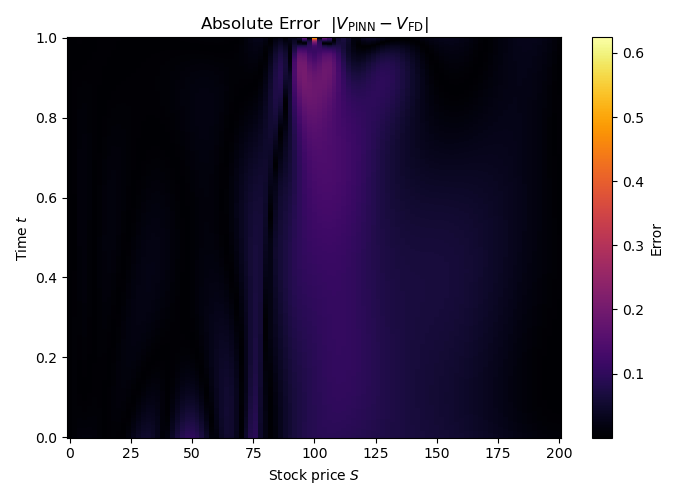

In [64]:
# ───────────────────────── 4)  FIGURE 2 – error heat-map ────────────
fig2, ax_err = plt.subplots(figsize=(7, 5))
pcm = ax_err.pcolormesh(SS, TT, err_np,
                        shading='auto', cmap='inferno')
ax_err.set_title(r'Absolute Error  $|V_{\mathrm{PINN}}-V_{\mathrm{FD}}|$')
ax_err.set_xlabel('Stock price $S$')
ax_err.set_ylabel('Time $t$')
fig2.colorbar(pcm, ax=ax_err, label='Error')
fig2.tight_layout()
plt.show()

In [65]:
np.linalg.norm(err_np, 2) / np.linalg.norm(v_fd, 2)  # relative L2 error

np.float64(0.0013021884738217463)

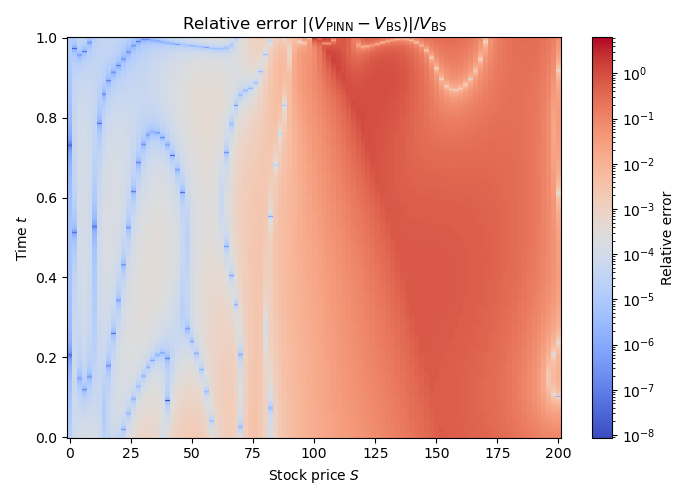

In [66]:
import matplotlib.colors as mcolors
eps = 1e-1                # pick something ≪ typical option value
den  = np.maximum(np.abs(v_fd), eps)
rel_err_np  = np.abs(V_pinn_np - v_fd) / den

# --- plot -------------------------------------------------------------------
fig3 = plt.figure(figsize=(7, 5))
ax3  = fig3.add_subplot(111)

# A log-colour scale makes the small errors visible
log_norm = mcolors.LogNorm(vmin=np.nanmin(rel_err_np[rel_err_np>0]),
                           vmax=np.nanmax(rel_err_np))

cmesh = ax3.pcolormesh(SS, TT, rel_err_np,
                       shading='auto',
                       cmap='coolwarm',
                       norm=log_norm)         # <- log scale

ax3.set_title(r'Relative error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})| / V_{\mathrm{BS}}$')
ax3.set_xlabel('Stock price $S$')
ax3.set_ylabel('Time $t$')

cb = fig3.colorbar(cmesh, ax=ax3, label='Relative error')
cb.update_ticks()

fig3.tight_layout()
plt.show()


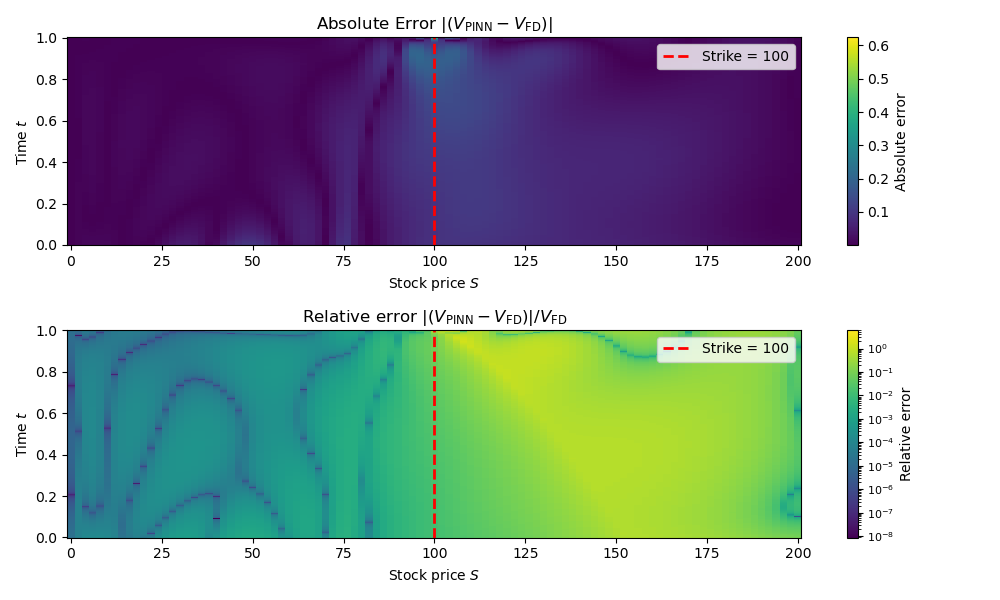

In [67]:
# Create figure with proper size for subplots
fig2 = plt.figure(figsize=(10, 6))

# rel_err_np = np.abs(V_pinn_np - v_fd) / np.where(np.abs(v_fd) > eps,
#                                                     v_fd,
#                                                     np.nan)

# Absolute error plot
ax1 = fig2.add_subplot(2, 1, 1)
cmesh1 = ax1.pcolormesh(SS, TT, err_np, cmap='viridis')
ax1.set_title(r'Absolute Error $|(V_{\mathrm{PINN}}-V_{\mathrm{FD}})|$')
ax1.set_xlabel('Stock price $S$')
ax1.set_ylabel('Time $t$')
ax1.axvline(x=STRIKE, color='red', linestyle='--', linewidth=2, label=f'Strike = {STRIKE}')
ax1.legend()
fig2.colorbar(cmesh1, ax=ax1, label='Absolute error')

# Relative error plot
ax2 = fig2.add_subplot(2, 1, 2)

# Filter out zero/nan values for better log normalization
valid_rel_err = rel_err_np[~np.isnan(rel_err_np) & (rel_err_np > 0)]
if len(valid_rel_err) > 0:
    log_norm = mcolors.LogNorm(vmin=np.min(valid_rel_err), 
                               vmax=np.max(valid_rel_err))
else:
    log_norm = None

cmesh2 = ax2.pcolormesh(SS, TT, rel_err_np, cmap='viridis', norm=log_norm)
ax2.set_title(r'Relative error $|(V_{\mathrm{PINN}}-V_{\mathrm{FD}})| / V_{\mathrm{FD}}$')
ax2.set_xlabel('Stock price $S$')
ax2.set_ylabel('Time $t$')
ax2.axvline(x=STRIKE, color='red', linestyle='--', linewidth=2, label=f'Strike = {STRIKE}')
ax2.legend()

# Create colorbar with fewer ticks to avoid overlap
cb = fig2.colorbar(cmesh2, ax=ax2, label='Relative error')
if log_norm is not None:
    cb.ax.tick_params(labelsize=8)  # Smaller font size
    # Manually set fewer tick locations if needed
    cb.set_ticks([10**i for i in range(int(np.log10(np.min(valid_rel_err))), 
                                      int(np.log10(np.max(valid_rel_err)))+1)])

plt.tight_layout()
plt.show()

def free_boundary_put(vals, s_grid, K, tol=1e-8):
    payoff = np.maximum(K - s_grid, 0.0)      # vector (ns,)
    nt, ns = vals.shape
    S_star = np.full(nt, np.nan, dtype=float)

    for j in range(nt):
        # --- look *only* where payoff>0  (i.e. S < K) -----------------------
        diff = vals[j] - payoff
        inside = np.where((payoff > 0.0) & (diff <= tol))[0]

        if inside.size == 0:
            continue                          # never touches payoff on this row

        i = inside[-1] + 1                    # first node *above* the payoff
        if i >= ns or payoff[i] == 0:         # safety: boundary at last pos
            S_star[j] = s_grid[min(i, ns - 1)]
        else:
            # Linear interpolation between nodes i‑1 (on) and i (off)
            w = diff[i-1] / (diff[i-1] - diff[i])
            S_star[j] = (1 - w) * s_grid[i-1] + w * s_grid[i]

    return S_star

S_star_fd   = free_boundary_put(v_fd, s_fd, STRIKE)   # FD reference
S_star_pinn = free_boundary_put(V_pinn_np, s_fd, STRIKE)   # PINN surface


# ----- 2)  Overlay on the heat‑maps already stored in fig2 --------
for ax in [ax1, ax2]:              # ax1 = absolute, ax2 = relative error
    ax.plot(S_star_fd,   t_fd, color='cyan',   label='FD boundary')
    ax.plot(S_star_pinn, t_fd, color='yellow', linestyle='--', label='PINN boundary')
    # optional aesthetics
    ax.invert_yaxis()              # puts “today” at the top (optional)
    ax.legend(loc='upper right')   # move if it obscures data

plt.draw()  


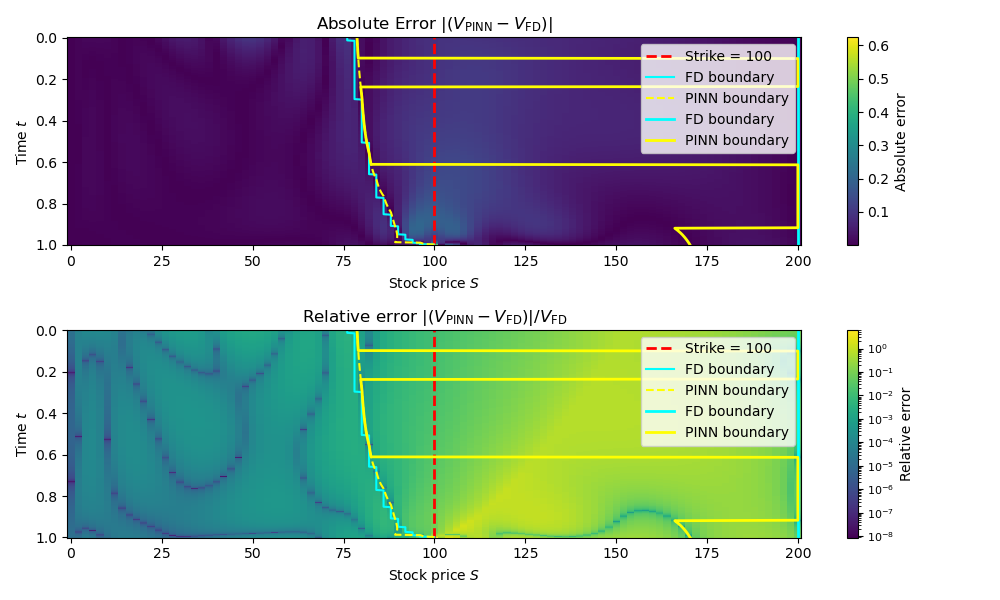

In [68]:
# %% ---------------------------------------------------------------
# 1)  Utility to locate the early‑exercise boundary
def free_boundary(vals, s_grid, K, tol=1e-10):
    """
    vals   : (nt, ns) option values on a (t, S) mesh
    s_grid : (ns,)    stock‑price grid (ascending)
    K      : strike
    tol    : slack when comparing to the payoff grid
    """
    payoff = np.maximum(K - s_grid, 0.0)
    nt, ns = vals.shape
    S_star = np.empty(nt)

    for j in range(nt):
        diff = vals[j] - payoff            # 0 where V == payoff
        idx  = np.where(diff <= tol)[0]    # still in exercise region
        if len(idx) == 0:                  # never touches payoff
            S_star[j] = np.nan
        else:
            i = idx[-1]                    # last point inside region
            if i == ns - 1:
                S_star[j] = s_grid[-1]
            else:                          # linear interp → smoother curve
                w = diff[i] / (diff[i] - diff[i+1])
                S_star[j] = (1-w)*s_grid[i] + w*s_grid[i+1]

    return S_star


# 2)  Extract boundaries from each surface
S_star_fd   = free_boundary(v_fd,      s_fd, STRIKE)
S_star_pinn = free_boundary(V_pinn_np, s_fd, STRIKE)

# 3)  Overlay on the *existing* figure (fig2) -----------------------
# fig2 ax1 = absolute‑error heat‑map, ax2 = relative‑error heat‑map
for ax in [ax1, ax2]:
    ax.plot(S_star_fd,   t_fd, color='cyan',  lw=2, label='FD boundary')
    ax.plot(S_star_pinn, t_fd, color='yellow',lw=2, label='PINN boundary')
    ax.legend(loc='upper right')           # adjust if it overlaps
    # (Optional) reverse y‑axis if you prefer today at top:
    # ax.invert_yaxis()

plt.show()  # refresh the figure if running in an interactive backend
